In [1]:
# ls

In [1]:
# Parameters
INPUT_FILE = './data/champ6_raw.csv'
MAX_ORDER = 10
# SCORE_LIST = [13,8,5,3,2,1,1,1,1,1]
SCORE_LIST = [8,5,3,2,1,0,0,0,0,0]
# SCORE_LIST = [8,5,3,2,1,1,1,1,1,1]

assert len(SCORE_LIST) == MAX_ORDER

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.cluster import hierarchy
from sklearn.cluster import AgglomerativeClustering

In [3]:
# ประทับเวลา	ที่อยู่อีเมล	ชื่อ-นามสกุล ภาษาไทย	ชื่อเล่น	รหัสนิสิต	ชั้นปี	Pair ที่สนใจลำดับที่ 1	Pair ที่สนใจลำดับที่ 2	Pair ที่สนใจลำดับที่ 3	Pair ที่สนใจลำดับที่ 4	Pair ที่สนใจลำดับที่ 5	Pair ที่สนใจลำดับที่ 6	Pair ที่สนใจลำดับที่ 7	Pair ที่สนใจลำดับที่ 8	Pair ที่สนใจลำดับที่ 9	Pair ที่สนใจลำดับที่ 10
COLUMNS = ['timestamp', 'email', 'name_th', 'nickname', 'id', 'year']
RANK_COLS = [f'rank_{i}' for i in range(1, 11)]

In [4]:
def replace_nan(data):
    """Replace NaN Value
        If a column contains numerical value, replace it with 0.
        Otherwise, replace it with 'UNKNOWN'"""
    
    df = data.copy()
    for col in df.columns:
        if df[col].dtype in ['int64', 'float64']:
            df[col].fillna(0, inplace = True)
        else:
            df[col].fillna('UNKNOWN', inplace = True)
    return df

def tier_multiply(score, tier):
    """Multiply scores of each candidate by his/her respective tier
    """
    new = score.copy()
    new['tier'] = tier
    new = new.apply(lambda x: x * x['tier'])
    return new

In [5]:
pre_df = pd.read_csv(INPUT_FILE)
pre_df.columns = COLUMNS + RANK_COLS
# pre_df.set_index('id', inplace=True)
meta_df = pre_df.loc[:, COLUMNS].set_index('id')
rank_df = pre_df.loc[:, ['id'] + RANK_COLS] #.set_index('id')
# tier = pre_df.pop('tier')
# tier.index = pre_df.ID
# tier.head()
# pre_df.head()
rank_df.head(2)

,id,rank_1,rank_2,rank_3,rank_4,rank_5,rank_6,rank_7,rank_8,rank_9,rank_10
0,6531301721,"Pair 7: คุณกฤตภาส สิริภัสสร (พี่ก้อง), คุณอภิน...","Pair 9: คุณพิชิต พงษ์ประเสริฐ (พี่ไปรท์), คุณว...","Pair 11: ดร.ศรุต วานิชพันธ์ุ (พี่รัมย์), คุณเป...","Pair 8: คุณไพโรจน์ กวียานันท์ (พี่บูน), คุณปัญ...","Pair 12: คุณศิริวัฒน์ วงศ์จารุกร (พี่เล้ง), คุ...","Pair 13: คุณวรภัทร ชวนะนิกุล (พี่เบนซ์), คุณวี...","Pair 2: คุณอดิศัย ธรรมร่มดี(พี่แซม), ดร.ชวพล จ...","Pair 17: คุณรัชดา ด่านพงษ์เจริญ (พี่อ้อ), คุณร...","Pair 3: นายอครินทร์ ภูรีสิทธิ์ (พี่ต้น), คุณถึ...","Pair 14: คุณชลิยา จุลโมกข์ สุชาโต (พี่แนท), คุ..."
1,6338202321,"Pair 12: คุณศิริวัฒน์ วงศ์จารุกร (พี่เล้ง), คุ...","Pair 9: คุณพิชิต พงษ์ประเสริฐ (พี่ไปรท์), คุณว...","Pair 14: คุณชลิยา จุลโมกข์ สุชาโต (พี่แนท), คุ...","Pair 15: คุณปกรณ์ ธรรมภิมุขวัฒนา (พี่เหน่ง), ค...",Pair 1: คุณจีรวัฒน์ สิทธิ์สันต์กุล (พี่เจมส์ จ...,"Pair 2: คุณอดิศัย ธรรมร่มดี(พี่แซม), ดร.ชวพล จ...","Pair 3: นายอครินทร์ ภูรีสิทธิ์ (พี่ต้น), คุณถึ...","Pair 4: คุณปพนธ์ มังคละธนะกุล (พี่ปะ), คุณกวีว...","Pair 5: คุณสุรัตน์ ประลองศิลป์ (พี่ปู), คุณโทน...","Pair 6: คุณสุธี อัสววิมล (พี่โหน่ง), คุณกิตติธ..."


In [33]:
rank_df[rank_df.index == '6330002721']

,id,rank_1,rank_2,rank_3,rank_4,rank_5,rank_6,rank_7,rank_8,rank_9,rank_10


In [6]:
# top pairs of pairs
# rank_df.groupby(['rank_1', 'rank_2'])['id'].nunique()
pairs_list = [['rank_1', 'rank_2'], ['rank_1', 'rank_3']]
top_ranks = []
for pairs in pairs_list:
    tmp = rank_df.loc[:, ['id'] + pairs]
    # tmp['v1'] = tmp[pairs].min(axis=1)
    # tmp['v2'] = tmp[pairs].max(axis=1)
    tmp['v1'] = tmp[pairs[0]]
    tmp['v2'] = tmp[pairs[1]]
    top_ranks.append(tmp[['id', 'v1', 'v2']])

top_ranks_df = pd.concat(top_ranks, axis=0)
# top_ranks_df.head()
top_ranks_count = top_ranks_df.groupby(['v1', 'v2'])[['id']].count().reset_index() \
                .rename(columns={'id': 'n_att'})
top_ranks_count.sort_values(by='n_att', ascending=False).head(30)

,v1,v2,n_att
61,"Pair 2: คุณอดิศัย ธรรมร่มดี(พี่แซม), ดร.ชวพล จ...","Pair 4: คุณปพนธ์ มังคละธนะกุล (พี่ปะ), คุณกวีว...",9
87,"Pair 6: คุณสุธี อัสววิมล (พี่โหน่ง), คุณกิตติธ...","Pair 10: คุณวชิระชัย คูนำวัฒนา (พี่โจโจ้), คุณ...",6
97,"Pair 7: คุณกฤตภาส สิริภัสสร (พี่ก้อง), คุณอภิน...","Pair 12: คุณศิริวัฒน์ วงศ์จารุกร (พี่เล้ง), คุ...",5
63,"Pair 2: คุณอดิศัย ธรรมร่มดี(พี่แซม), ดร.ชวพล จ...","Pair 6: คุณสุธี อัสววิมล (พี่โหน่ง), คุณกิตติธ...",5
62,"Pair 2: คุณอดิศัย ธรรมร่มดี(พี่แซม), ดร.ชวพล จ...","Pair 5: คุณสุรัตน์ ประลองศิลป์ (พี่ปู), คุณโทน...",5
14,"Pair 13: คุณวรภัทร ชวนะนิกุล (พี่เบนซ์), คุณวี...","Pair 17: คุณรัชดา ด่านพงษ์เจริญ (พี่อ้อ), คุณร...",4
99,"Pair 7: คุณกฤตภาส สิริภัสสร (พี่ก้อง), คุณอภิน...","Pair 15: คุณปกรณ์ ธรรมภิมุขวัฒนา (พี่เหน่ง), ค...",4
83,"Pair 4: คุณปพนธ์ มังคละธนะกุล (พี่ปะ), คุณกวีว...","Pair 6: คุณสุธี อัสววิมล (พี่โหน่ง), คุณกิตติธ...",4
80,"Pair 4: คุณปพนธ์ มังคละธนะกุล (พี่ปะ), คุณกวีว...","Pair 2: คุณอดิศัย ธรรมร่มดี(พี่แซม), ดร.ชวพล จ...",4
56,"Pair 2: คุณอดิศัย ธรรมร่มดี(พี่แซม), ดร.ชวพล จ...","Pair 11: ดร.ศรุต วานิชพันธ์ุ (พี่รัมย์), คุณเป...",4


In [7]:
# n = 18
# top_ranks_count[(top_ranks_count['v1'].str.contains(f'Pair {n}')) | (top_ranks_count['v2'].str.contains(f'Pair {n}'))]

# Data Preprocessing

In [8]:
df = replace_nan(rank_df)
df.isnull().sum().sum()

0

In [9]:
# df[['rank_1', 'id']].groupby('rank_1')[['id']].nunique().sort_values(by='id', ascending=False)

In [10]:
melt_df = pd.melt(df, id_vars='id', var_name='rank', value_name='pair')
melt_df['rank'] = melt_df['rank'].str.replace('rank_', '').astype(int)
melt_df['pair'] = melt_df['pair'].apply(lambda x: x.split(':')[0].lower().replace(' ', '_'))

score_transform = {k: v for k, v in zip(range(1, MAX_ORDER + 1), SCORE_LIST)}
melt_df['score'] = melt_df['rank'].replace(score_transform)

pair_rank_df = pd.pivot_table(melt_df, values='score', columns='pair', index='id', aggfunc='max') # .fillna(-99.0)

# reorder columns
reordered_cols = [f'pair_{i}' for i in range(1, 19)]
pair_rank_df = pair_rank_df[reordered_cols]
pair_rank_df.head()

pair,pair_1,pair_2,pair_3,pair_4,pair_5,pair_6,pair_7,pair_8,pair_9,pair_10,pair_11,pair_12,pair_13,pair_14,pair_15,pair_16,pair_17,pair_18
id,,,,,,,,,,,,,,,,,,
6330002721,2.0,1.0,3.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,8.0,0.0,0.0,NaN,5.0,NaN
6330013621,2.0,3.0,0.0,NaN,NaN,8.0,0.0,NaN,NaN,0.0,0.0,NaN,NaN,1.0,NaN,NaN,5.0,0.0
6330022221,2.0,0.0,NaN,0.0,5.0,0.0,NaN,NaN,NaN,NaN,NaN,0.0,8.0,1.0,NaN,0.0,3.0,NaN
6330034821,NaN,0.0,0.0,NaN,NaN,2.0,8.0,3.0,NaN,0.0,0.0,1.0,NaN,NaN,5.0,NaN,0.0,NaN
6330038321,NaN,NaN,0.0,0.0,3.0,5.0,NaN,1.0,NaN,NaN,NaN,0.0,2.0,0.0,0.0,8.0,NaN,NaN


In [11]:
# melt_df.groupby(['id', 'pair'])[['rank']].count().sort_values(by='pair', ascending=False)

# Multiply Tier

In [12]:
# df_tier = df.set_index('ID')
# df_tier['tier'] = tier
# df_tier.head()

In [13]:
# for candidate in df_tier.index:
#     tier_score = df_tier.loc[candidate, 'tier']
#     df_tier.loc[candidate] = df_tier.loc[candidate].apply(lambda x: x * tier_score)

In [14]:
# df_tier.drop('tier', axis = 1, inplace = True)
# df_tier.head()

In [15]:
# Let df = df_tier (for scripts below)
# df = df_tier

# Correlation Matrix

In [23]:
pair_rank_df.head()

pair,pair_1,pair_2,pair_3,pair_4,pair_5,pair_6,pair_7,pair_8,pair_9,pair_10,pair_11,pair_12,pair_13,pair_14,pair_15,pair_16,pair_17,pair_18
id,,,,,,,,,,,,,,,,,,
6330002721,2.0,1.0,3.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,8.0,0.0,0.0,NaN,5.0,NaN
6330013621,2.0,3.0,0.0,NaN,NaN,8.0,0.0,NaN,NaN,0.0,0.0,NaN,NaN,1.0,NaN,NaN,5.0,0.0
6330022221,2.0,0.0,NaN,0.0,5.0,0.0,NaN,NaN,NaN,NaN,NaN,0.0,8.0,1.0,NaN,0.0,3.0,NaN
6330034821,NaN,0.0,0.0,NaN,NaN,2.0,8.0,3.0,NaN,0.0,0.0,1.0,NaN,NaN,5.0,NaN,0.0,NaN
6330038321,NaN,NaN,0.0,0.0,3.0,5.0,NaN,1.0,NaN,NaN,NaN,0.0,2.0,0.0,0.0,8.0,NaN,NaN


In [16]:
# pair_score = df[[col for col in df if 'pair' in col]]
corr = pair_rank_df.corr().fillna(0)
corr.index.name = ''
corr_table = corr.unstack().reset_index()
corr_table.columns = ['p1', 'p2', 'corr']

# top correlation
corr_table[corr_table['p1'] > corr_table['p2']].sort_values(by='corr', ascending=False).head(10)

,p1,p2,corr
141,pair_8,pair_16,0.992286
303,pair_17,pair_16,0.552158
306,pair_18,pair_1,0.432112
99,pair_6,pair_10,0.374482
283,pair_16,pair_14,0.317886
189,pair_11,pair_10,0.288316
280,pair_16,pair_11,0.278618
302,pair_17,pair_15,0.272528
137,pair_8,pair_12,0.260913
154,pair_9,pair_11,0.260394


# Dendrogram

Text(0.5, 1.0, 'Dendrogram of weighted applicant ranks')

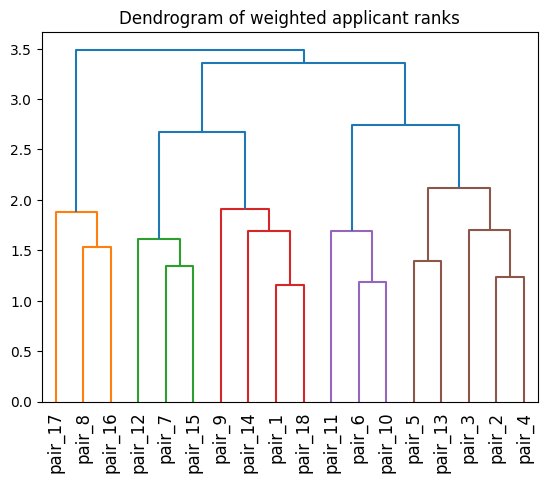

In [17]:
den = hierarchy.dendrogram(hierarchy.linkage(corr, method = 'ward'),
                           labels = corr.index,
                           leaf_rotation=90)
plt.title('Dendrogram of weighted applicant ranks')

In [19]:
# Final data to put into those unsupervised learning models
# pair_score.head()

# Principal Component Analysis

In [20]:
from sklearn.decomposition import PCA

In [28]:
# pair_rank_df

In [25]:
pca_input = pair_rank_df.T.fillna(-1)
pca = PCA(n_components=2).fit(pca_input)

In [34]:
pca_score = pca.transform(pca_input)

# Explained variance ratio
pca.explained_variance_ratio_

array([0.1751199 , 0.12647905])

In [36]:
# pca_score[:,0]

array([ -2.651345  ,  30.96730364,  -1.24532143,  16.19875897,
        -0.16017886,   7.84100962,  10.48493573,  -3.31789916,
        -9.74854443,  -3.80307391,  -2.07803295,   1.46618308,
        -7.27062774,  -4.08862658,  -4.98479329, -10.86725061,
        -5.26920024, -11.47329685])

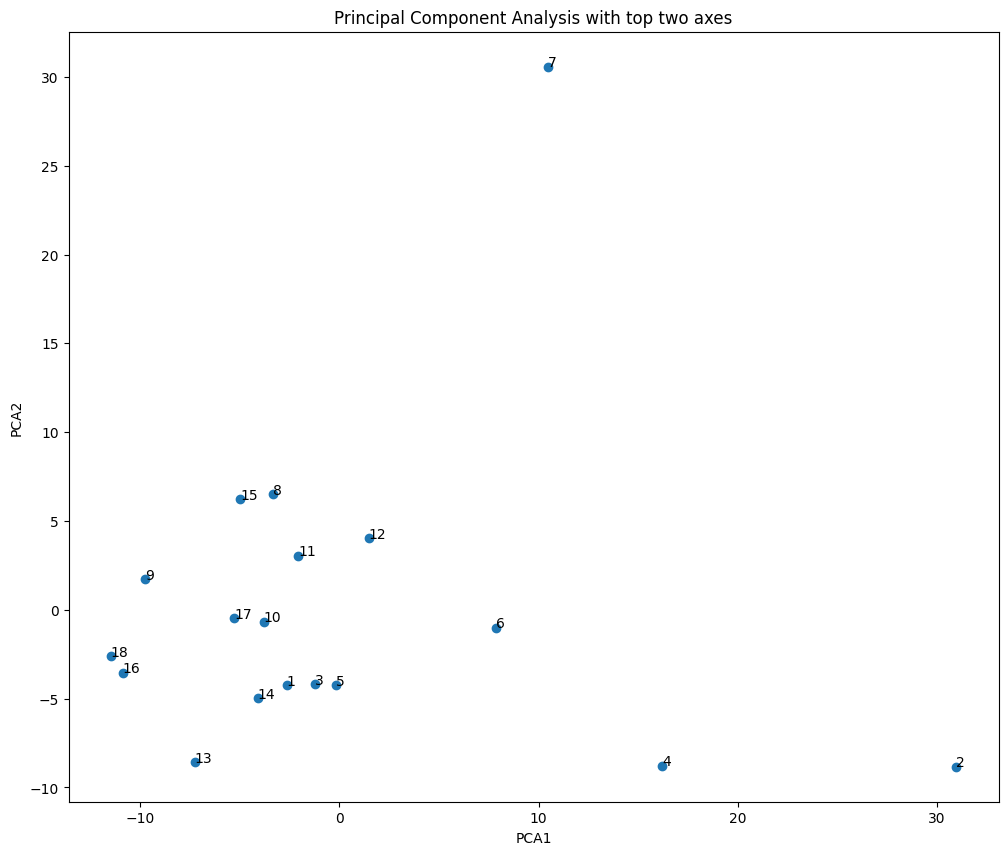

In [37]:
plt.figure(figsize = (12,10))
plt.scatter(pca_score[:,0], pca_score[:,1])
# sns.scatterplot(pca_score[:,0], pca_score[:,1], alpha = 0.5)
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.title('Principal Component Analysis with top two axes')

# Annotate label for each dot
for i in range(pca_score.shape[0]):
    plt.annotate(str(i+1), (pca_score[i,0], pca_score[i,1]))

plt.show()

# Truncated Singular Value Decomposition

In [73]:
from sklearn.decomposition import TruncatedSVD

In [74]:
tsvd = TruncatedSVD(n_components=2, random_state=73).fit(pair_score.T)
tsvd_score = tsvd.transform(pair_score.T)

tsvd.explained_variance_ratio_

array([0.16537476, 0.15505945])

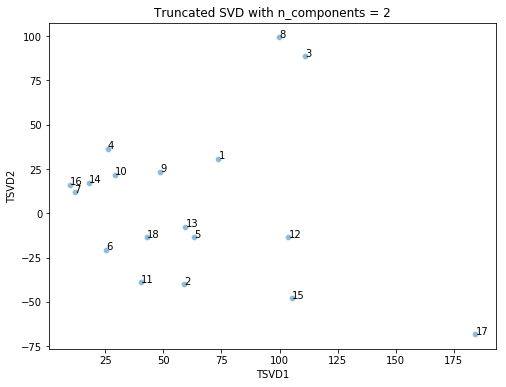

In [75]:
plt.figure(figsize = (8,6))
#plt.scatter(pca_score[:,0], pca_score[:,1])
sns.scatterplot(tsvd_score[:,0], tsvd_score[:,1], alpha = 0.5)
plt.xlabel('TSVD1')
plt.ylabel('TSVD2')
plt.title('Truncated SVD with n_components = 2')

# Annotate label for each dot
for i in range(tsvd_score.shape[0]):
    plt.annotate(str(i+1), (tsvd_score[i,0], tsvd_score[i,1]))

plt.show()

# Extra: Pair Score Sum

In [76]:
df.sum(axis = 0).iloc[1:].astype(int).sort_values(ascending = False)

pair 17    1544
pair 3     1054
pair 15    1044
pair 8      951
pair 12     928
pair 5      654
pair 13     650
pair 2      632
pair 9      528
pair 18     515
pair 11     485
pair 6      334
pair 10     325
pair 4      291
pair 14     251
pair 7      169
pair 16     152
dtype: int64

# 3D Plot from PCA

In [77]:
import plotly.express as px
from sklearn.preprocessing import MinMaxScaler

In [78]:
pca_3x = PCA(n_components=3).fit(pair_score.T)
pca_3x_score = pca_3x.transform(pair_score.T)

print('Explained variance ratio: %.2f' % (sum(pca_3x.explained_variance_ratio_) * 100))

Explained variance ratio: 47.49


In [79]:
plt.figure(figsize = (10,10))
fig = px.scatter_3d(x = pca_3x_score[:, 0], y = pca_3x_score[:, 1],
                    z = pca_3x_score[:, 2], text = [str(i+1) for i in range(18)],
                    opacity = 0.3, title = '3D Principal Component Analysis Visualization')

fig.update_layout(scene = dict(xaxis = dict(showgrid = False, showticklabels = False),
                               yaxis = dict(showgrid = False, showticklabels = False),
                               zaxis = dict(showgrid = False, showticklabels = False)))
fig.show()

<Figure size 720x720 with 0 Axes>

In [33]:
pca_3rd = pca_3x_score[:, 2]
pca_3rd_scale = MinMaxScaler().fit_transform(pca_3rd.reshape(1, -1))
pca_3rd_scale

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.]])

In [34]:
pca_3rd

array([ 17.47868479, -14.39490922,  19.04852118,  -6.71529511,
         5.67250085,  -0.35353556,  -2.89505181, -16.91564313,
         1.27040988,  -4.07335231,   6.9178253 ,  -0.51415465,
        -1.22833269,  -0.81154768,  22.5403033 ,  -6.9424234 ,
       -12.72711699,  -5.35688276])